In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip -q install pdfplumber seaborn sentence-transformers scikit-learn unidecode


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 111.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 99.2 MB/s eta 0:00:00


In [2]:
import os, re, glob
import pdfplumber
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from unidecode import unidecode
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sentence_transformers import SentenceTransformer
from collections import Counter


sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (7,4)


In [3]:
# Define os diretórios de trabalho (base, PDFs e saída dos resultados)
BASE = "/content/drive/MyDrive/pcj_analise"
PDF_DIR = f"{BASE}/pdf"
OUT_DIR = f"{BASE}/resultados"
os.makedirs(OUT_DIR, exist_ok=True)  # cria pasta de saída se não existir

# Lista e exibe todos os arquivos PDF encontrados na pasta
pdf_files = sorted(glob.glob(os.path.join(PDF_DIR, "*.pdf")))
print(f"Arquivos encontrados ({len(pdf_files)}):")
for f in pdf_files:
    print(" -", os.path.basename(f))



Arquivos encontrados (9):
 - abr_2025.pdf
 - ago_2025.pdf
 - fev_2025.pdf
 - jan_2025.pdf
 - jul_2025.pdf
 - jun_2025.pdf
 - mai_2025.pdf
 - mar_2025.pdf
 - set_2025.pdf


Funções de extração e limpeza

In [4]:
# Limpa o texto extraído, removendo espaços duplos e caracteres especiais dos PDFs
def basic_clean(text):
    return re.sub(r"[ \t]{2,}", " ", text.replace("\xa0"," ")).strip()

# Lê todas as páginas de um PDF e extrai o texto limpo de cada uma
def extract_pdf_text(path):
    pages = []
    with pdfplumber.open(path) as pdf:
        for p in pdf.pages:
            txt = p.extract_text() or ""  # extrai texto da página
            pages.append(basic_clean(txt))  # aplica limpeza
    return pages

# Identifica o mês e o ano a partir do nome do arquivo (ex: "fev2023" → "2023-02")
def guess_month_year(fn):
    meses = dict(jan='01',fev='02',mar='03',abr='04',mai='05',jun='06',
                 jul='07',ago='08',set='09',out='10',nov='11',dez='12')
    s = fn.lower()
    m = re.search(r'(jan|fev|mar|abr|mai|jun|jul|ago|set|out|nov|dez)[^\d]*(\d{4})', s)
    if m:
        return f"{m.group(2)}-{meses[m.group(1)]}"
    return "desconhecido"

Função principal de extração (parse_numbers_from_text)

In [5]:
import re, os

def parse_numbers_from_text(pages, month_tag, file_name):
    """
    Extrai dados principais dos boletins PCJ:
    - Código da estação (ex: EF19)
    - Valores de chuva (mm), vazão (m³/s) e oxigênio (%)
    - Cada página representa uma estação
    """
    rows = []

    for pi, page in enumerate(pages, start=1):
        text = re.sub(r'\s+', ' ', page.replace('\n', ' '))  # limpa quebras de linha e espaços extras

        # Localiza o código da estação (ex: EF05, EF32)
        cod_match = re.search(r'\b(EF\d{1,3})\b', text, flags=re.IGNORECASE)
        if not cod_match:
            continue
        codigo_estacao = cod_match.group(1).upper().strip()

        # Localiza os três valores principais: chuva, vazão e oxigênio
        val_match = re.search(
            r'(?P<chuva>\d+(?:[.,]\d+)?)\s*mm.*?'
            r'(?P<vazao>\d+(?:[.,]\d+)?)\s*m[³3]\s*/\s*s.*?'
            r'(?P<oxig>\d+(?:[.,]\d+)?)\s*%',
            text, flags=re.IGNORECASE
        )

        if not val_match:
            continue  # pula se não encontrou os três valores

        # Converte valores para float, trocando vírgula por ponto
        chuva = float(val_match.group('chuva').replace(',', '.'))
        vazao = float(val_match.group('vazao').replace(',', '.'))
        oxig  = float(val_match.group('oxig').replace(',', '.'))

        # Adiciona os dados estruturados (um registro por métrica)
        for param, valor, unidade in [
            ('chuva', chuva, 'mm'),
            ('vazao', vazao, 'm3/s'),
            ('oxigenio', oxig, '%')
        ]:
            rows.append({
                'mes_ano': month_tag,
                'arquivo': os.path.basename(file_name),
                'pagina': pi,
                'parametro': param,
                'valor': valor,
                'unidade': unidade,
                'codigo_estacao': codigo_estacao
            })

    return rows


Executar extração para todos os boletins

In [6]:

all_rows = []
for pdf in pdf_files:
    pages = extract_pdf_text(pdf)
    month_tag = guess_month_year(os.path.basename(pdf))
    res = parse_numbers_from_text(pages, month_tag, pdf)
    print(f"{os.path.basename(pdf)}: {len(res)} registros extraídos")
    all_rows.extend(res)

df = pd.DataFrame(all_rows)
print("\nTotal de linhas extraídas:", len(df))
print("Códigos detectados:", sorted(df['codigo_estacao'].unique()))


abr_2025.pdf: 15 registros extraídos


ago_2025.pdf: 15 registros extraídos


fev_2025.pdf: 15 registros extraídos


jan_2025.pdf: 15 registros extraídos


jul_2025.pdf: 15 registros extraídos


jun_2025.pdf: 15 registros extraídos


mai_2025.pdf: 15 registros extraídos


mar_2025.pdf: 15 registros extraídos


set_2025.pdf: 15 registros extraídos

Total de linhas extraídas: 135
Códigos detectados: ['EF06', 'EF30', 'EF31', 'EF32', 'EF33']


In [7]:
print(sorted(df['codigo_estacao'].unique()))

['EF06', 'EF30', 'EF31', 'EF32', 'EF33']


Limpeza e pré-processamento

In [8]:
# Converte os dados extraídos (all_rows) em DataFrame
df = pd.DataFrame(all_rows)

# Remove linhas com campos vazios ou quebrados
df = df.dropna(subset=['mes_ano', 'codigo_estacao', 'parametro', 'valor'])

# Normaliza formatos e texto
df['mes_ano'] = df['mes_ano'].astype(str).str.strip()
df['codigo_estacao'] = df['codigo_estacao'].str.upper().str.strip()
df['parametro'] = df['parametro'].str.lower().str.strip()

# Converte números e corrige vírgulas
df['valor'] = (
    df['valor']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .astype(float)
)

# Remove duplicatas exatas (caso haja repetições)
df = df.drop_duplicates(subset=['mes_ano', 'codigo_estacao', 'parametro', 'valor'])

print("📊 Dados após limpeza e padronização:")
display(df.head(10))
print(f"Total de linhas após limpeza: {len(df)}")

📊 Dados após limpeza e padronização:


,mes_ano,arquivo,pagina,parametro,valor,unidade,codigo_estacao
0,2025-04,abr_2025.pdf,2,chuva,154.00,mm,EF31
1,2025-04,abr_2025.pdf,2,vazao,10.91,m3/s,EF31
2,2025-04,abr_2025.pdf,2,oxigenio,0.00,%,EF31
3,2025-04,abr_2025.pdf,3,chuva,122.40,mm,EF32
4,2025-04,abr_2025.pdf,3,vazao,2.23,m3/s,EF32
5,2025-04,abr_2025.pdf,3,oxigenio,0.28,%,EF32
6,2025-04,abr_2025.pdf,4,chuva,47.50,mm,EF30
7,2025-04,abr_2025.pdf,4,vazao,65.86,m3/s,EF30
8,2025-04,abr_2025.pdf,4,oxigenio,0.00,%,EF30
9,2025-04,abr_2025.pdf,5,chuva,61.80,mm,EF06


Total de linhas após limpeza: 135


Gerando data frame arrumado


In [9]:
# garantir que o mês está bem formatado
df['mes_ano'] = df['mes_ano'].astype(str)

# cria o pivot
df_resumo = (
    df.pivot_table(
        index=['mes_ano', 'codigo_estacao'],  # uma linha por mês e estação
        columns='parametro',
        values='valor',
        aggfunc='mean'  # média, caso haja duplicata
    )
    .reset_index()
    .rename_axis(None, axis=1)
)

# reordenar colunas
df_resumo = df_resumo[['mes_ano', 'codigo_estacao', 'chuva', 'vazao', 'oxigenio']]

# arredondar para leitura mais limpa
df_resumo = df_resumo.round(2)

display(df_resumo)
print(f"\nTotal de linhas: {len(df_resumo)}")

,mes_ano,codigo_estacao,chuva,vazao,oxigenio
0,2025-01,EF06,211.00,151.39,96.96
1,2025-01,EF30,161.00,117.14,4.78
2,2025-01,EF31,110.00,9.62,0.00
3,2025-01,EF32,193.00,2.16,0.67
4,2025-01,EF33,181.00,13.92,44.14
5,2025-02,EF06,151.00,159.31,2.38
6,2025-02,EF30,95.00,144.18,12.53
7,2025-02,EF31,159.00,12.89,0.00
8,2025-02,EF32,109.00,2.35,0.00
9,2025-02,EF33,152.00,19.45,30.36



Total de linhas: 45


In [ ]:

# 1️⃣ Dicionário de códigos → nomes dos rios
mapa_rios = {
    'EF31': 'Rio Atibaia',
    'EF32': 'Rio Jaguari',
    'EF30': 'Rio Piracicaba em Monte Alegre',
    'EF06': 'Rio Piracicaba em Artemis',
    'EF33': 'Rio Jundiaí'
}

# 2️⃣ Substituir os códigos pelos nomes
df_resumo['rio'] = df_resumo['codigo_estacao'].map(mapa_rios)
df_resumo.drop(columns='codigo_estacao', inplace=True)

# reorganizar colunas
df_resumo = df_resumo[['mes_ano', 'rio', 'chuva', 'vazao', 'oxigenio']]

# 3️⃣ Normalização Min–Max independente para cada métrica
scaler = MinMaxScaler()

for col in ['chuva', 'vazao', 'oxigenio']:
    df_resumo[f'{col}_norm'] = scaler.fit_transform(df_resumo[[col]])

# 4️⃣ Arredondar para facilitar leitura
df_resumo = df_resumo.round(3)

# 5️⃣ Mostrar resultado
display(df_resumo.head(15))

# 6️⃣ Salvar em Excel para uso nos gráficos
df_resumo.to_excel('df_resumo_normalizado.xlsx', index=False)
print("\n✅ Arquivo salvo como 'df_resumo_normalizado.xlsx'")

/tmp/ipython-input-3818140784.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resumo[f'{col}_norm'] = scaler.fit_transform(df_resumo[[col]])
/tmp/ipython-input-3818140784.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resumo[f'{col}_norm'] = scaler.fit_transform(df_resumo[[col]])
/tmp/ipython-input-3818140784.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

,mes_ano,rio,chuva,vazao,oxigenio,chuva_norm,vazao_norm,oxigenio_norm
0,2025-01,Rio Piracicaba em Artemis,211.00,151.39,96.96,1.000,0.950,0.970
1,2025-01,Rio Piracicaba em Monte Alegre,161.00,117.14,4.78,0.762,0.733,0.048
2,2025-01,Rio Atibaia,110.00,9.62,0.00,0.519,0.052,0.000
3,2025-01,Rio Jaguari,193.00,2.16,0.67,0.914,0.005,0.007
4,2025-01,Rio Jundiaí,181.00,13.92,44.14,0.857,0.080,0.441
5,2025-02,Rio Piracicaba em Artemis,151.00,159.31,2.38,0.714,1.000,0.024
6,2025-02,Rio Piracicaba em Monte Alegre,95.00,144.18,12.53,0.448,0.904,0.125
7,2025-02,Rio Atibaia,159.00,12.89,0.00,0.752,0.073,0.000
8,2025-02,Rio Jaguari,109.00,2.35,0.00,0.514,0.006,0.000
9,2025-02,Rio Jundiaí,152.00,19.45,30.36,0.719,0.115,0.304



✅ Arquivo salvo como 'df_resumo_normalizado.xlsx'


Análises descritivas

In [ ]:
print("=== Estatísticas Gerais das Métricas ===")

# 1️⃣ Estatísticas gerais de todas as variáveis medidas
display(df_resumo[['chuva', 'vazao', 'oxigenio']].describe().round(2))

# 2️⃣ Estatísticas por mês
print("\n=== Estatísticas por Mês ===")
estat_mensal = df_resumo.groupby('mes_ano')[['chuva', 'vazao', 'oxigenio']].mean().round(2)
display(estat_mensal)

# 3️⃣ Estatísticas por rio
print("\n=== Estatísticas por Rio ===")
estat_rio = df_resumo.groupby('rio')[['chuva', 'vazao', 'oxigenio']].mean().round(2)
display(estat_rio)

# 4️⃣ Contagem de registros por mês e rio (verificação de integridade)
print("\n=== Contagem de registros por mês e rio ===")
contagem = df_resumo.groupby(['mes_ano', 'rio']).size().reset_index(name='n')
display(contagem.head(15))

=== Estatísticas Gerais das Métricas ===


,chuva,vazao,oxigenio
count,45.00,45.00,45.00
mean,68.59,31.30,24.40
std,57.99,43.81,32.69
min,1.00,1.36,0.00
25%,24.00,3.89,0.00
50%,52.20,10.90,4.78
75%,109.00,32.61,44.14
max,211.00,159.31,100.00



=== Estatísticas por Mês ===


,chuva,vazao,oxigenio
mes_ano,,,
2025-01,171.20,58.85,29.31
2025-02,133.20,67.64,9.05
2025-03,83.16,42.25,5.83
2025-04,88.26,32.83,23.53
2025-05,33.47,22.55,43.24
2025-06,50.80,17.87,23.79
2025-07,20.00,14.23,34.65
2025-08,4.40,12.05,31.51
2025-09,32.80,13.40,18.72



=== Estatísticas por Rio ===


,chuva,vazao,oxigenio
rio,,,
Rio Atibaia,79.47,10.40,36.68
Rio Jaguari,69.53,1.75,0.11
Rio Jundiaí,66.98,7.64,19.07
Rio Piracicaba em Artemis,73.37,77.29,52.61
Rio Piracicaba em Monte Alegre,53.59,59.41,13.55



=== Contagem de registros por mês e rio ===


,mes_ano,rio,n
0,2025-01,Rio Atibaia,1
1,2025-01,Rio Jaguari,1
2,2025-01,Rio Jundiaí,1
3,2025-01,Rio Piracicaba em Artemis,1
4,2025-01,Rio Piracicaba em Monte Alegre,1
5,2025-02,Rio Atibaia,1
6,2025-02,Rio Jaguari,1
7,2025-02,Rio Jundiaí,1
8,2025-02,Rio Piracicaba em Artemis,1
9,2025-02,Rio Piracicaba em Monte Alegre,1


Visualizações

🔹 Preparando base e ordenando meses cronologicamente...

📊 [1/3] HISTOGRAMAS NORMALIZADOS — Distribuição geral das métricas
Mostra como os valores normalizados (0–1) de chuva, vazão e oxigênio estão distribuídos.
É útil pra comparar a variabilidade de cada parâmetro.



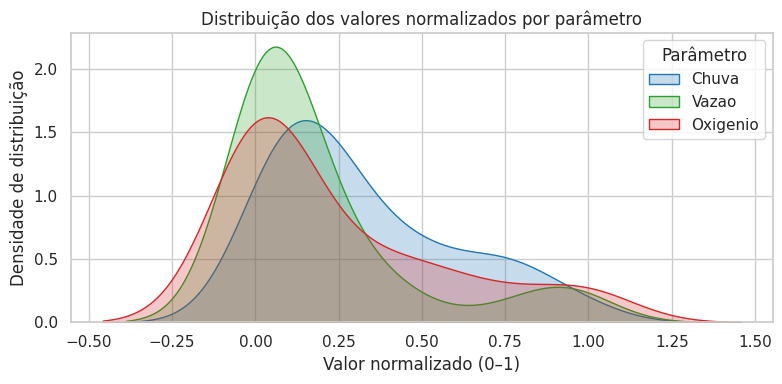


📈 [2/3] BOXPLOTS — Comparação entre os parâmetros originais
Cada caixa representa a variação (quartis) dos valores originais de chuva, vazão e oxigênio.
Serve para identificar outliers e diferenças de escala entre as métricas.



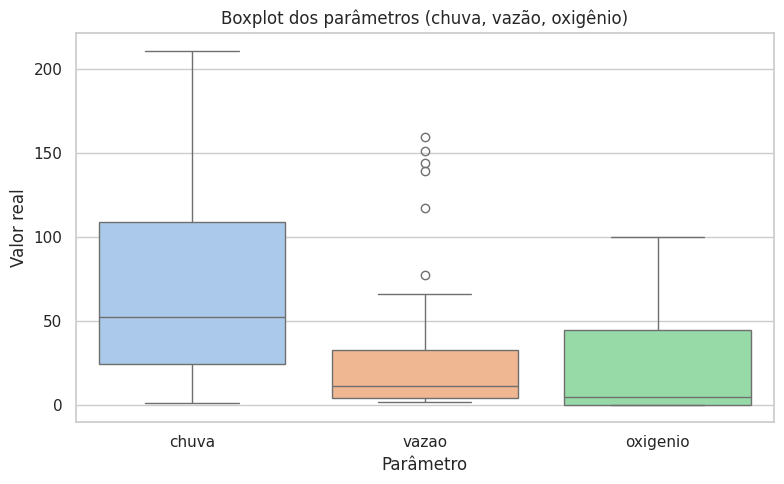


🌧 [3/3] TENDÊNCIA MENSAL — Evolução média por parâmetro e rio
Esses gráficos mostram como cada métrica varia ao longo dos meses para cada rio.
Cada linha colorida representa um rio diferente.



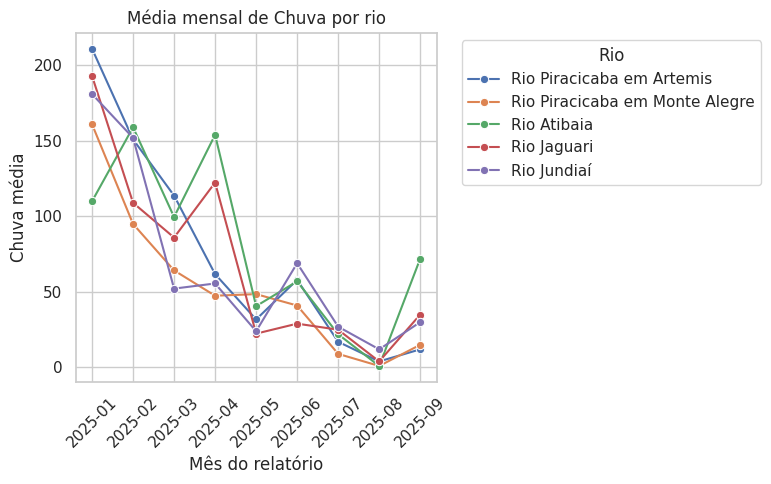

✅ Gráfico de tendência 'chuva' salvo em /resultados/graficos/tendencia_chuva.png



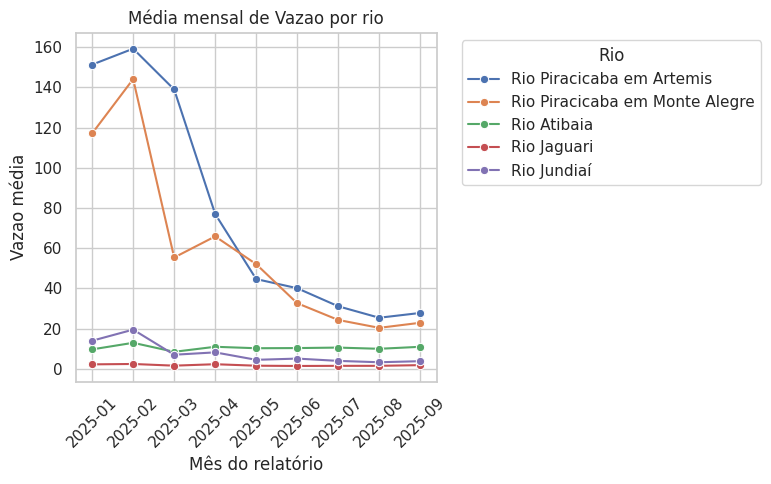

✅ Gráfico de tendência 'vazao' salvo em /resultados/graficos/tendencia_vazao.png



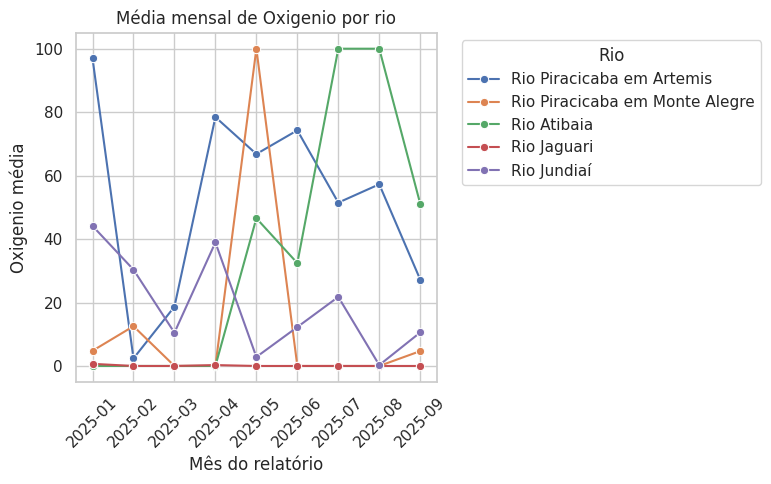

✅ Gráfico de tendência 'oxigenio' salvo em /resultados/graficos/tendencia_oxigenio.png



In [ ]:
print("🔹 Preparando base e ordenando meses cronologicamente...")
# Garante que os meses fiquem na ordem correta (jan → dez)
ordem_meses = ['jan', 'fev', 'mar', 'abr', 'mai', 'jun', 'jul', 'ago', 'set', 'out', 'nov', 'dez']
df_resumo['mes_ano'] = pd.Categorical(
    df_resumo['mes_ano'],
    ordered=True,
    categories=sorted(df_resumo['mes_ano'].unique(),
                      key=lambda x: ordem_meses.index(x[:3].lower()) if x[:3].lower() in ordem_meses else 99)
)

# -----------------------------------------------------------------------------
print("\n📊 [1/3] HISTOGRAMAS NORMALIZADOS — Distribuição geral das métricas")
print("Mostra como os valores normalizados (0–1) de chuva, vazão e oxigênio estão distribuídos.")
print("É útil pra comparar a variabilidade de cada parâmetro.\n")

# HISTOGRAMAS NORMALIZADOS (usando as colunas *_norm)
plt.figure(figsize=(8, 4))
for col, color in zip(['chuva_norm', 'vazao_norm', 'oxigenio_norm'], ['#1f77b4', '#2ca02c', '#d62728']):
    sns.kdeplot(df_resumo[col], fill=True, common_norm=False,
                label=col.replace('_norm', '').capitalize(), color=color)

plt.title("Distribuição dos valores normalizados por parâmetro")
plt.xlabel("Valor normalizado (0–1)")
plt.ylabel("Densidade de distribuição")
plt.legend(title="Parâmetro")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
print("\n📈 [2/3] BOXPLOTS — Comparação entre os parâmetros originais")
print("Cada caixa representa a variação (quartis) dos valores originais de chuva, vazão e oxigênio.")
print("Serve para identificar outliers e diferenças de escala entre as métricas.\n")

# Transforma os dados em formato longo (para facilitar o uso no Seaborn)
df_melted = df_resumo.melt(
    id_vars=['mes_ano', 'rio'],
    value_vars=['chuva', 'vazao', 'oxigenio'],
    var_name='Parâmetro',
    value_name='Valor'
)

plt.figure(figsize=(8,5))
sns.boxplot(x='Parâmetro', y='Valor', data=df_melted, palette='pastel')
plt.title("Boxplot dos parâmetros (chuva, vazão, oxigênio)")
plt.xlabel("Parâmetro")
plt.ylabel("Valor real")
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
print("\n🌧 [3/3] TENDÊNCIA MENSAL — Evolução média por parâmetro e rio")
print("Esses gráficos mostram como cada métrica varia ao longo dos meses para cada rio.")
print("Cada linha colorida representa um rio diferente.\n")

# Cria pasta para salvar os gráficos, se desejar
graf_path = os.path.join(OUT_DIR, "graficos")
os.makedirs(graf_path, exist_ok=True)

# Loop para criar um gráfico por parâmetro (chuva, vazão, oxigênio)
for parametro in ['chuva', 'vazao', 'oxigenio']:
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_resumo,
        x='mes_ano',
        y=parametro,
        hue='rio',
        marker='o'
    )
    plt.title(f"Média mensal de {parametro.capitalize()} por rio")
    plt.xlabel("Mês do relatório")
    plt.ylabel(f"{parametro.capitalize()} média")
    plt.xticks(rotation=45)
    plt.legend(title="Rio", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Salva o gráfico em PNG dentro da pasta /resultados/graficos
    plt.savefig(os.path.join(graf_path, f"tendencia_{parametro}.png"), bbox_inches='tight')
    plt.show()

    print(f"✅ Gráfico de tendência '{parametro}' salvo em /resultados/graficos/tendencia_{parametro}.png\n")

🔹 Iniciando análise PCA (chuva, vazão, oxigênio)...

🔸 Variância explicada por componente:
PC1: 47.19%
PC2: 35.11%
Total: 82.30%


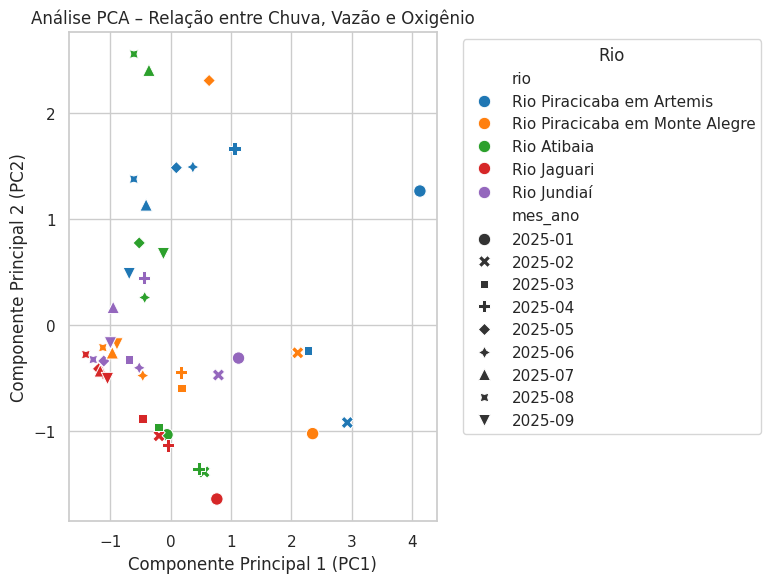


🔸 Correlação entre as métricas (coeficiente de Pearson):


,chuva,vazao,oxigenio
chuva,1.000,0.396,-0.069
vazao,0.396,1.000,0.190
oxigenio,-0.069,0.190,1.000


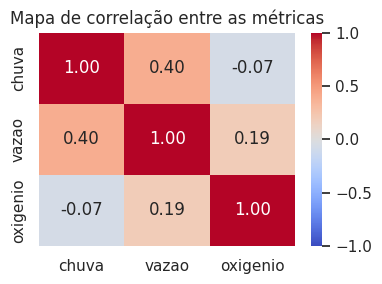

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("🔹 Iniciando análise PCA (chuva, vazão, oxigênio)...")

# 1️⃣ Seleciona apenas as colunas de interesse
X = df_resumo[['chuva', 'vazao', 'oxigenio']]

# 2️⃣ Padroniza os dados (média=0, desvio padrão=1) — essencial para PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3️⃣ Executa o PCA com 2 componentes principais
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# 4️⃣ Cria um DataFrame com os resultados e informações adicionais
df_pca = pd.DataFrame({
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'rio': df_resumo['rio'],
    'mes_ano': df_resumo['mes_ano']
})

# 5️⃣ Mostra a variância explicada
print("\n🔸 Variância explicada por componente:")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Total: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# 6️⃣ Gráfico PCA com cores por rio
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='rio', style='mes_ano', palette='tab10', s=80)
plt.title("Análise PCA – Relação entre Chuva, Vazão e Oxigênio")
plt.xlabel("Componente Principal 1 (PC1)")
plt.ylabel("Componente Principal 2 (PC2)")
plt.legend(title="Rio", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 7️⃣ Correlação entre as variáveis originais
print("\n🔸 Correlação entre as métricas (coeficiente de Pearson):")
corr = df_resumo[['chuva', 'vazao', 'oxigenio']].corr().round(3)
display(corr)

plt.figure(figsize=(4,3))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title("Mapa de correlação entre as métricas")
plt.tight_layout()
plt.show()


Salvar dados tratados

In [ ]:
import os

# cria a pasta de saída se não existir
os.makedirs(OUT_DIR, exist_ok=True)

# salvar o arquivo
output_csv = os.path.join(OUT_DIR, "df_resumo_normalizado.csv")
df_resumo.to_csv(output_csv, index=False, sep=';', encoding='utf-8-sig')

print(f"✅ Arquivo CSV salvo em:\n{output_csv}")



✅ Arquivo CSV salvo em:
/content/drive/MyDrive/pcj_analise/resultados/df_resumo_normalizado.csv
